In [8]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
from pynput.keyboard import Listener
import logging
from scipy.io.wavfile import write

%matplotlib notebook


def read_arduino(ser,inputBufferSize):
#    data = ser.readline(inputBufferSize)
    data = ser.read(inputBufferSize)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return np.flip(result)

In [9]:
# use this to find ports
from serial.tools import list_ports

ports = list_ports.comports()
for port in ports:
    print(port)

/dev/cu.URT0 - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.iPhone-WirelessiAPv2 - n/a


<IPython.core.display.Javascript object>


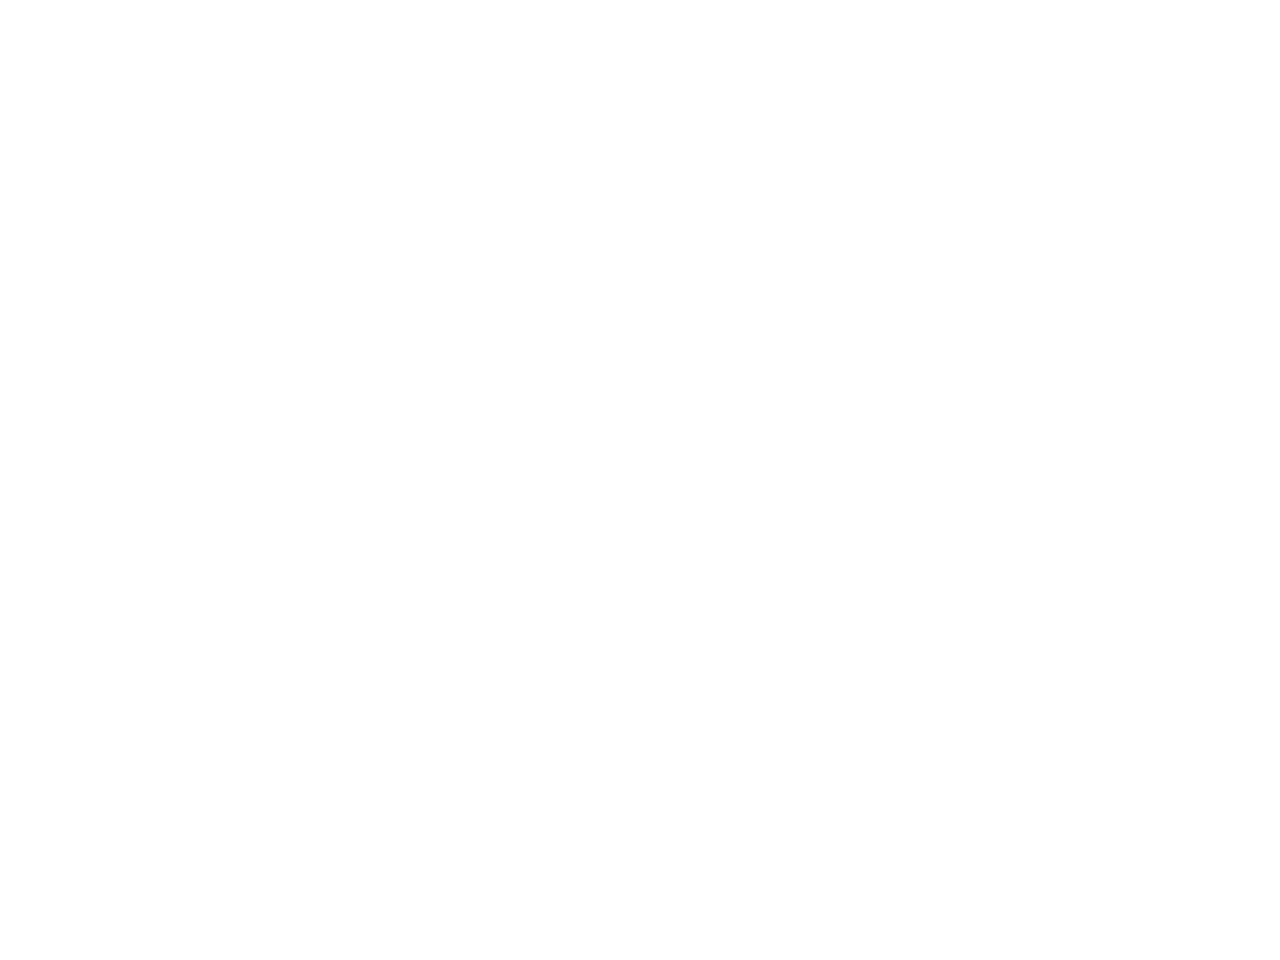

In [10]:
# Read example data
baudrate = 230400
# cport = '/dev/cu.usbmodem142301'  # set the correct port before you run it
cport = "/dev/cu.URT0"
#cport = '/dev/tty.usbmodem141101'  # set the correct port before run it
ser = serial.Serial(port=cport, baudrate=baudrate)    
# take example data
inputBufferSize = 10000 # 20000 = 1 second
ser.timeout = inputBufferSize/20000.0  # set read timeout
#ser.set_buffer_size(rx_size = inputBufferSize)
data = read_arduino(ser,inputBufferSize)
data_plot = process_data(data)
plt.figure()
plt.plot(data_plot)
plt.show()
 

In [11]:
# this initializes the animated plot
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


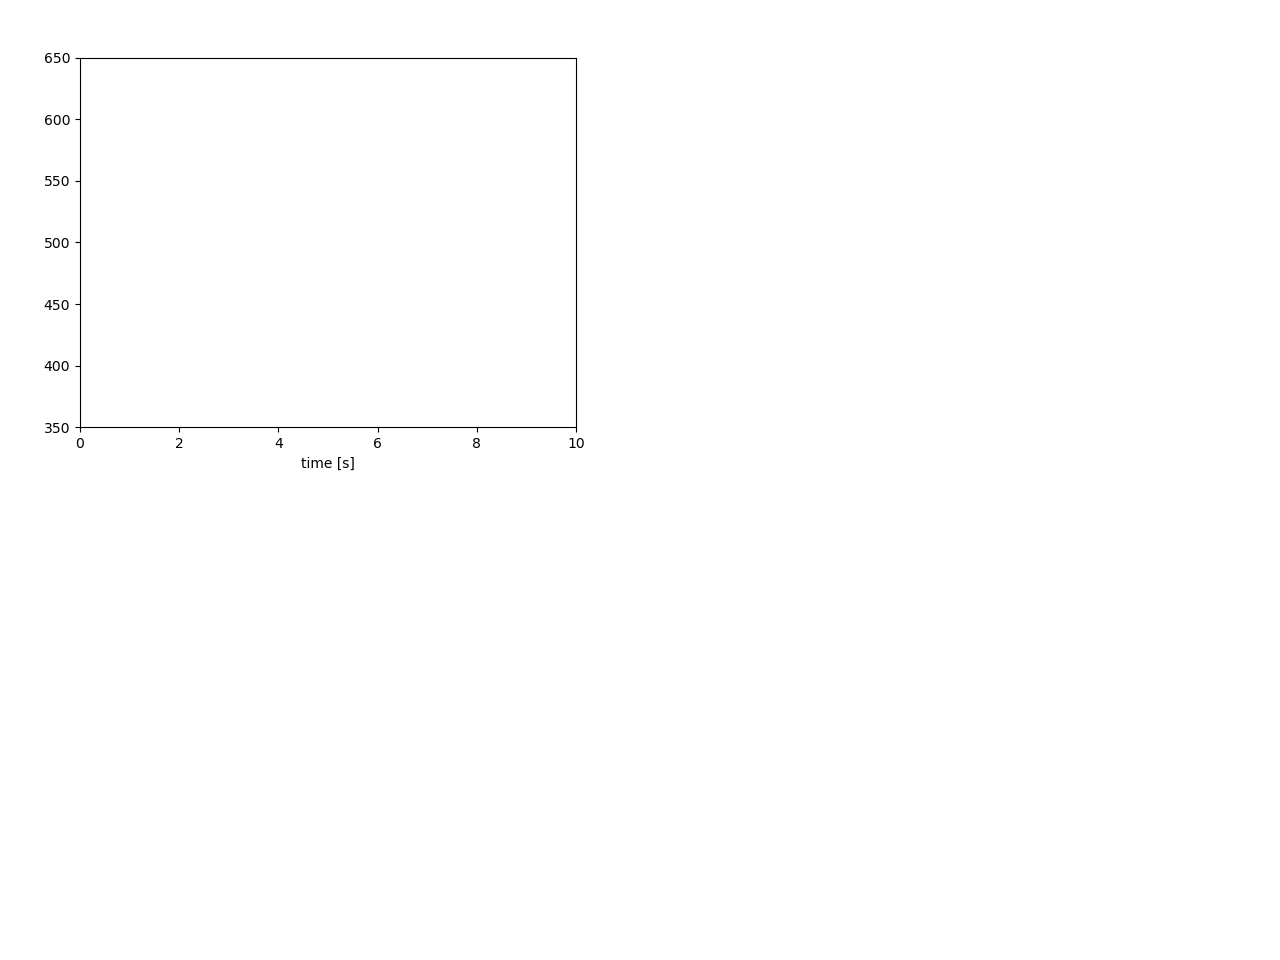

AttributeError: 'list' object has no attribute 'dtype'

In [12]:
# take continuous data stream 
inputBufferSize = 2000 # keep betweein 2000-20000
ser.timeout = inputBufferSize/20000.0  # set read timeout, 20000 is one second
#this is the problem line on the mac
# ser.set_buffer_size(rx_size = inputBufferSize)

%matplotlib notebook

# Change this total_time variable to change how long the live stream is
total_time = 5.0; # time in seconds [[1 s = 20000 buffer size]]
max_time = 10.0; # time plotted in window [s]
N_loops = 20000.0/inputBufferSize*total_time

T_acquire = inputBufferSize/20000.0    # length of time that data is acquired for 
N_max_loops = max_time/T_acquire    # total number of loops to cover desire time window

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plt.ion()
fig.show()
fig.canvas.draw()
total = []


for k in range(0,int(N_loops)):
    data = read_arduino(ser,inputBufferSize)
    data_temp = process_data(data)

    total.append(data_temp)

    if k <= N_max_loops:
        if k==0:
            data_plot = data_temp
        else:
            data_plot = np.append(data_temp,data_plot)
        t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    else:
        data_plot = np.roll(data_plot,len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
    t = (min(k+1,N_max_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)


#    plt.xlim([0,max_time])
    ax1.clear()
    ax1.set_xlim(0, max_time)
    plt.xlabel('time [s]')
    plt.ylim([350, 650])
    ax1.plot(t,data_plot)
    fig.canvas.draw()    
    plt.show()


samplerate = 10000;
# saving streamed data to wav file
write("filename.wav", samplerate, total)


In [13]:
# close serial port if necessary
if ser.read():
    ser.flushInput()
    ser.flushOutput()
    ser.close()